# Long & Short -- Método da Cointegração

Esse Script foi feito na maior parte pelo autor:
- Fábio Oliveira de Paula - fabio.olp@gmail.com
com o grupo Outspoken Market no discord: Link para a Comunidade no Discord: https://discord.gg/rbJskh8

-O local na comunidade onde está a troca de informações sobre este script,
é no repositório de códigos da comunidade, link:https://discord.com/channels/736151809873149952/736195045740249100/744942333279076412

Eu Lucas Eduardo Fiz algumas contribuições, corrigindo alguns erros que tinha na implementação da  meia-vida e implementei outros pontos a fim de melhorar o script como: correlação, expoent de hurst e grafíco de ratio dos dois ativos.

Script feito Baseado nos ensinamentos de:
- Leandro Guerra
- Fábio Figueiredo

Comentários:
- Este script realiza a análise por cointegração de um determinado par de ativos e para um determinado período.
- Está dividido em partes para facilitar a compreensão tanto do estudo quanto da funcionalidade do método.
- Tentei deixar o máximo comentado para facilitar a compreensão, mas podem fica à vontade de perguntar o que não entender.
- Esse código tem o objetivo de esclarecer sobre os cálculos da cointegração, porém posteriormente, pode ser executado em loop para verificar diversos parâmetros e diversos períodos.

****

##### Importa bibliotecas

[*********************100%***********************]  2 of 2 completed


<AxesSubplot:xlabel='Date'>

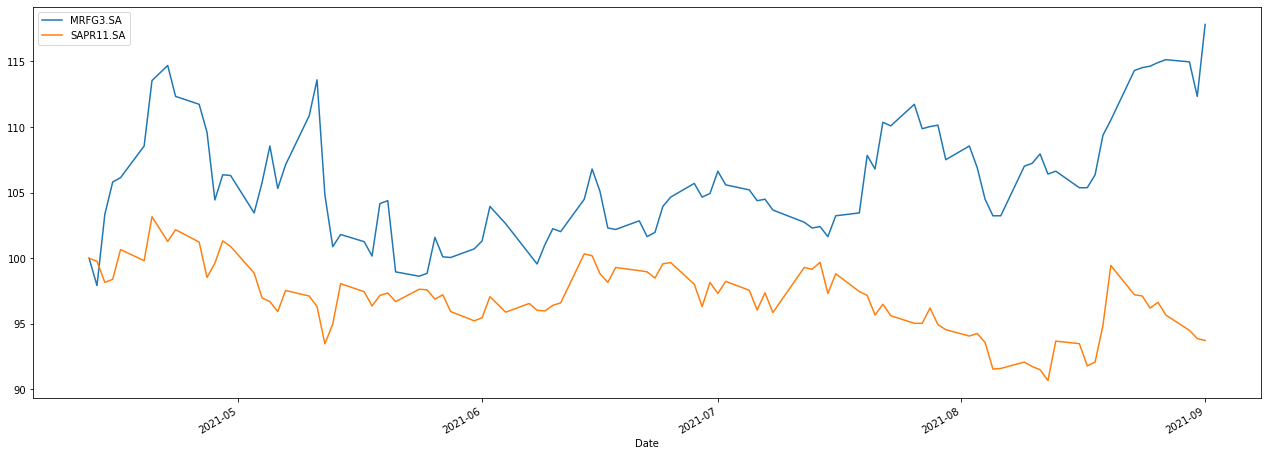

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from scipy import stats
import statsmodels.api as sm 
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import statsmodels.tsa.stattools as ts 
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

np.random.seed(42)

# Escolher aqui o par de ativos à analisar
tickers = "	 MRFG3.SA SAPR11.SA "
#tickers = raw_input("	  ")
##carteira = we(tickers, start="2y")["Adj Close"]-GGBR4.SA BBSE3.SA-RENT3.SA BBSE3.SA-LREN3.SA GGBR4.SA-LREN3.SA GOAU4.SA-
#-EQTL3.SA BBSE3.SA

#-LREN3.SA GOAU4.SA-MULT3.SA GOAU4.SA-TAEE11.SA RADL3.SA-BBSE3.SA SANB11-BBSE3.SA GOAU4.SA-CIEL3.SA SANB11.SA-
#-NTCO3.SA GOAU4.SA-CCRO3.SA ABEV3.SA
dados = yf.download(tickers=tickers, period="5y")['Adj Close']

janelas = [100, 120, 140, 160, 180, 200, 220, 240, 250]
# indices   0    1    2    3    4    5    6    7    8
tamanho_base = janelas[0] # Setar aqui o periodo que se deseja analisar, baseado na lista acima

pairs = pd.DataFrame()
pairs = dados[(dados.index >= dados.index[-tamanho_base])]

#------------------------------------------------------------------

# Elimina dados faltantes
pairs = pairs.dropna()

# Normalizamos para 100 e vemos como os 2 ativos desempenharam nesse periodo
(pairs / pairs.iloc[0] * 100).plot(figsize=(22, 8))

[*********************100%***********************]  2 of 2 completed


<AxesSubplot:>

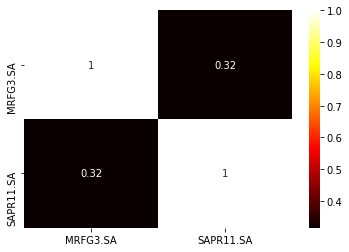

In [5]:
#Correlação de Pearson entre os dois ativos!
import seaborn as sns

carteira = yf.download(tickers, start="2007-01-01")["Adj Close"]
sns.heatmap(carteira.corr(), annot=True, cmap='hot')#CMAP='PiYG, RdBu, YlGnBu, hot'

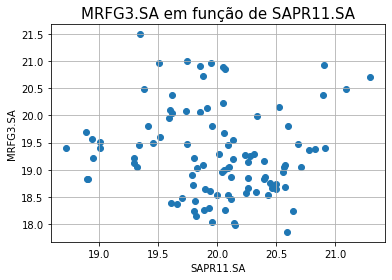

In [6]:
# Obtem o nome dos ativos
ativo_A = tickers.split()[0]
ativo_B = tickers.split()[1]

# Atribui cada ativo às variáveis X e Y
dados_ativo_A = pairs[ativo_A]
dados_ativo_B = pairs[ativo_B]

# Plota o gráfico de dispersão com um ativo em função do outro
plt.scatter(dados_ativo_B,dados_ativo_A)
plt.xlabel(ativo_B)
plt.ylabel(ativo_A)

plt.title('{} em função de {}'.format(ativo_A, ativo_B), size=15)
plt.grid()
    
    
plt.show()

<AxesSubplot:xlabel='Date'>

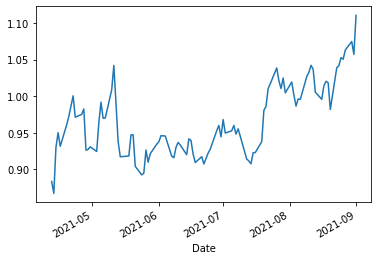

In [7]:
#Gera o retio dos dois ativos
spread = dados_ativo_A/dados_ativo_B

spread.plot()

In [8]:
# Gera a regressão linear
X1 = sm.add_constant(dados_ativo_B) # inclui uma constante no modelo
reg = sm.OLS(dados_ativo_A, X1).fit() # regressão de minimos quadrados ordinários
#reg.summary()

# Atribui parâmetros da regressão à variáveis e imprime valores
slope, intercept, r_value, p_value, std_err = stats.linregress(dados_ativo_B, dados_ativo_A)

print("Inclinação (Beta): . {:.2f}".format(slope))
print("Intercept (Alfa): .. {:.2f}".format(intercept))
print("R2: ................ {:.2f}".format(r_value**2))
print("P-valor: ........... {:.2f}".format(p_value))
print("Erro padrão: ....... {:.2f}".format(std_err))

Inclinação (Beta): . -0.09
Intercept (Alfa): .. 21.19
R2: ................ 0.00
P-valor: ........... 0.54
Erro padrão: ....... 0.16


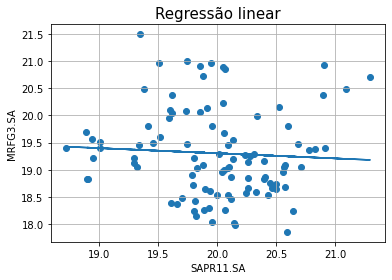

In [9]:
# Função para predição
def fitline(b):
    return intercept + slope * b

# Acrescenta a coluna 'Predicao' no DataFrame original dos dados e atribui os dados preditos
pairs["Predicao"] = fitline(dados_ativo_B)

# Plota reta da Regressão linear
plt.scatter(dados_ativo_B, dados_ativo_A)
plt.plot(dados_ativo_B, pairs["Predicao"])
plt.title('Regressão linear', size=15)
plt.xlabel(ativo_B, size=10)
plt.ylabel(ativo_A, size=10)
plt.grid()
plt.show()

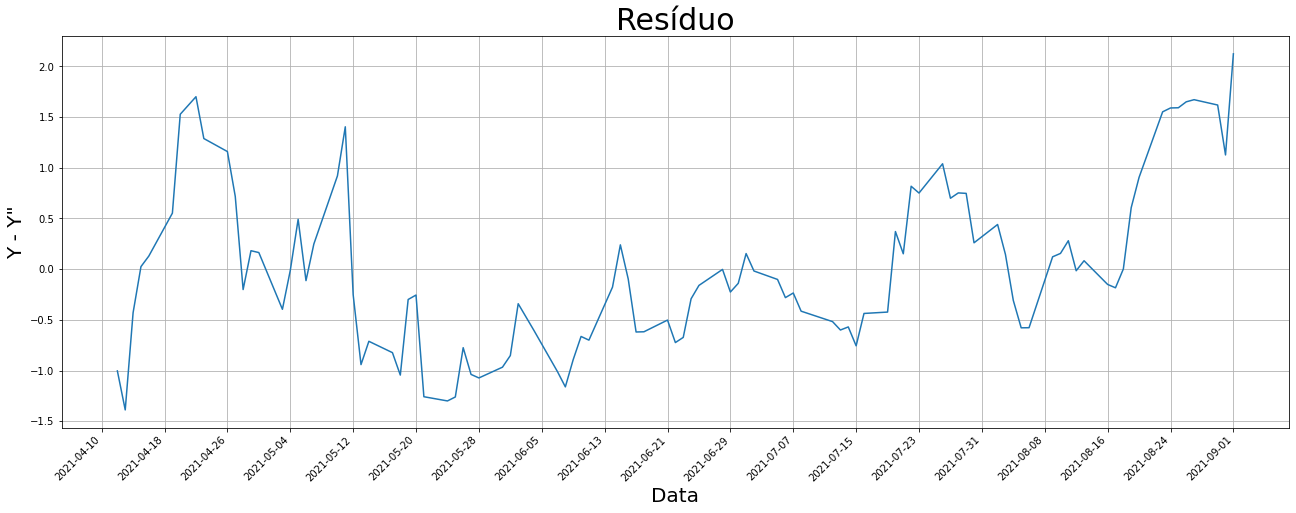

In [10]:
# Gera a coluna 'Resíduo' no DataFrame original e atribui os valores da subtração do Ativo em Y com os dados Preditos
# (Resíduo = Erro)
pairs["Residuo"] =  reg.resid #ou dados_ativo_A - intercept - slope * dados_ativo_B  

# Plota o resíduo
import matplotlib.dates as mdates

pairs["Residuo"].plot(figsize=(22,8))
plt.title('Resíduo', size=30)
plt.xlabel('Data', size=20)
plt.ylabel('Y - Y"', size=20)
plt.xticks(pairs.index.tolist())

plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))

plt.grid()

In [11]:
# Teste Dickey-Fuller
# Verifica se o Resíduo é estacionário ou não.
# Para isso, verifica se tem distribuição normal
# O par apresenta cointegração apenas se o Resíduo for estacionário

# Importa bibliotecas para esse teste
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

# Atribui os dados do Resíduo à variável A
dados_residuo = pairs['Residuo']#""

# Atribui à variável 'result' o resultado do teste
result = adfuller(dados_residuo)

# Imprime o resultado com explicação
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('Chance de ser não estacionária: {:.2f} %'.format(result[1]*100))
    
# Margem de aceitação para Stop Gain
range_aceitacao = 0.05
print()
print("Range do p-value configurado como aceito: {}".format(range_aceitacao))
print()

# Para considerar como estacionarias, p-valor deve ser < 5% (0.05)
if result[1] < range_aceitacao:
    print('Ativos cointegrados -> LS OK')
else:
    print('Ativos não cointegrados -> LS descartado')

ADF Statistic: -2.183412
p-value: 0.212321
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.583
Chance de ser não estacionária: 21.23 %

Range do p-value configurado como aceito: 0.05

Ativos não cointegrados -> LS descartado


Gerando Estratégia...



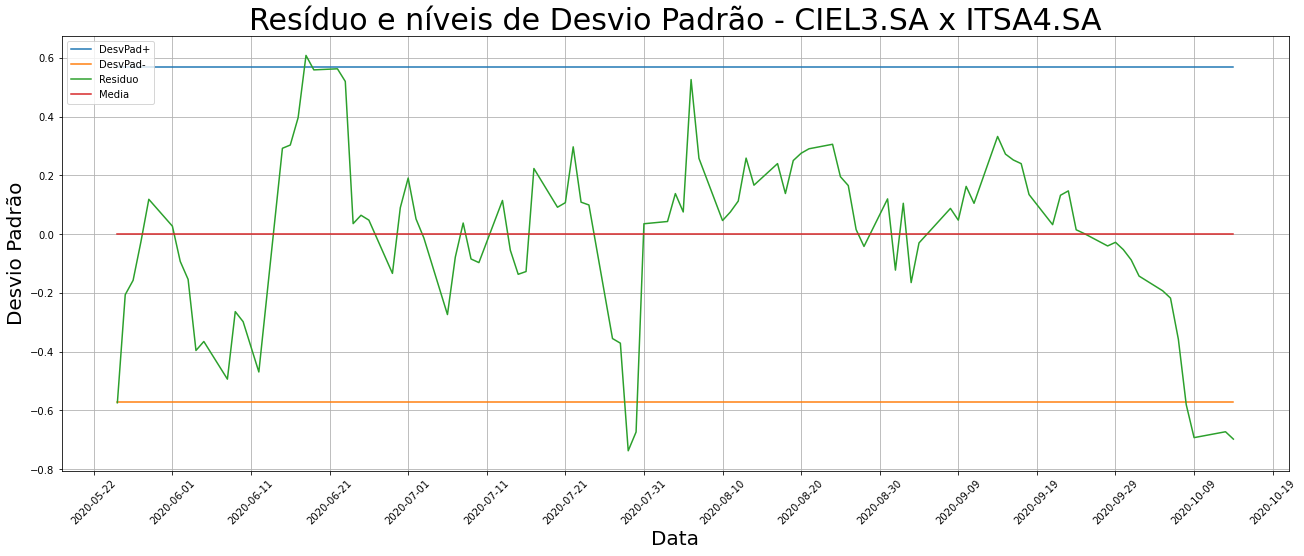


CIEL3.SA x ITSA4.SA
    COMPRA: 0.75 ações de CIEL3.SA
    VENDA : 1 ações de ITSA4.SA



In [38]:
# ESTRATÉGIA
# Se cointegração ok, continuar com Estratégia

from statistics import stdev

# Apenas se forem cointegrados
if result[1] < range_aceitacao:
    print("Gerando Estratégia...")
    print()
    
    # Obtem o Desvio Padrão dos Resíduos
    desvPad = stdev(pairs["Residuo"])
    
    # Cria 2 colunas com 2x Desvio Padrão (+ e -) e 1 coluna com a média em Zero
    pairs["DesvPad+"] =  2*desvPad
    pairs["DesvPad-"] = -2*desvPad
    pairs["Media"] = 0

    # Cria 2 colunas com 2x Desvio Padrão (+ e -) e 1 coluna com a média em Zero
    plt.figure(figsize=(22,8))
    plt.plot(pairs["DesvPad+"], label='DesvPad+')
    plt.plot(pairs["DesvPad-"], label='DesvPad-')
    plt.plot(pairs["Residuo"], label='Residuo')
    plt.plot(pairs["Media"], label='Media')
    titulo_grafico = 'Resíduo e níveis de Desvio Padrão - ' + ativo_A + ' x ' + ativo_B
    plt.title(titulo_grafico, size=30)
    plt.xlabel('Data', size=20)
    plt.ylabel('Desvio Padrão', size=20)
    plt.xticks(pairs.index.tolist())
    plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 45)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.grid()
    plt.legend(loc='upper left')
    plt.show()
    
    #------------------------------------------------------------------------

    if (pairs['Residuo'][-1] < pairs['DesvPad-'][-1]): # Residuo fora do DP
        # Então compra-se o Ativo Y e vende-se o Ativo X
        
        beta = abs(slope)
        qtd_acoes_a = 0
        qtd_acoes_b = 0

        qtd_acoes_a = 1
        qtd_acoes_b = qtd_acoes_a * beta

        print()
        print(ativo_A + ' x ' + ativo_B)
        
        print("    COMPRA: {} ações de {}".format(round(qtd_acoes_b,2), ativo_A)) 
        print("    VENDA : {} ações de {}".format(round(qtd_acoes_a,2), ativo_B))

        print()
        
    elif (pairs['Residuo'][-1] > pairs['DesvPad+'][-1]): # Residuo fora do DP
        # Então, compra-se o Ativo X e vende-se o Ativo Y
        
        beta = abs(slope)
        qtd_acoes_a = 0
        qtd_acoes_b = 0

        qtd_acoes_a = 1000
        qtd_acoes_b = qtd_acoes_a * beta

        print()
        print(ativo_A + ' x ' + ativo_B)

        print("    COMPRA: {} ações de {}".format(round(qtd_acoes_a,2), ativo_B)) 
        print("    VENDA : {} ações de {}".format(round(qtd_acoes_b,2), ativo_A))

        print()
        
    else:
        print('Nada à fazer')
    
# Avisa para o caso de que não haja cointegração
else:
    print("Não há cointegração. Par e período descartados") 

In [39]:
# Meia vida
from sklearn import linear_model
df_close = spread.to_frame()
df_lag = df_close.shift(1)
df_delta = df_close - df_lag
lin_reg_model = linear_model.LinearRegression()
df_delta = df_delta.values.reshape(len(df_delta),1)                    
df_lag = df_lag.values.reshape(len(df_lag),1)
lin_reg_model.fit(df_lag[1:], df_delta[1:])                          
half_life = -np.log(2) / lin_reg_model.coef_.item()
print ('Half life:       %s' % half_life)         

# ADF
adf = result[0]
print("ADF: {:.2f}".format(adf))
    
#Coeficiente de Hurst
from hurst import compute_Hc
# compute_Hc retornos
H, c, val = compute_Hc(spread)
# Plot o grafíco
#axes = plt.subplots()[1]
#axes.plot(val[0], c*val[0]**H, color="blue")
#axes.scatter(val[0], val[1], color="red")
#axes.set_xscale('log')
#axes.set_yscale('log')
#axes.set_xlabel('Time interval')
#axes.set_ylabel('R/S ratio')
#axes.grid(True)
#plt.show()

# print do expoente de hurst
print("Hurst exponent = {:.4f}".format(H))
# Coeficiente de Hurst vai de 0 a 1
# Considerações abaixo:
# H = 0,5 - movimento browniano,
# H >0,5 até 1,0 - comportamento de tendência persistente
# 0 <H <0,5 - comportamento retorno a média.

Half life:       4.910351109752305
ADF: -3.39
Hurst exponent = 0.3661
